# Tutorial: dynamic GRN inference from SHARE-seq dataset of mouse skin
# Step 2: dynamic GRN inference and analysis with Dictys
This is a [Dictys](https://github.com/pinellolab/dictys) tutorial to reconstruct and analyze dynamic GRNs from the SHARE-seq dataset of mouse skin. This notebook is step 2 that reconstructs and analyzes dynamic GRNs with Dictys. You should have completed running [main1.ipynb](main1.ipynb).

This is the same dataset as the one used in the paper, but you should not expect it reproduce the figures. This is because the tutorial aims to demonstrate the reconstruction of dynamic GRNs not provided in the paper. Use tutorial [analysis-skin](https://github.com/pinellolab/dictys/tree/master/doc/tutorials/analysis-skin) if you want to redraw the figures.

Before running, you need to **change the runtime configurations** for your machine at [2. Network inference configuration](#2.-Network-inference-configuration) and [3. Dynamic network inference](#3.-Dynamic-network-inference).

If you face any issues or need any assistance, see [FAQ](https://github.com/pinellolab/dictys#faq) and [Issues](https://github.com/pinellolab/dictys#issues).

## 1. Preparation of individual input files in `data` folder
The following files/folders are already prepared. If you need to know how they are prepared, see the [short-multiome](https://github.com/pinellolab/dictys/tree/master/doc/tutorials/short-multiome) or [full-multiome](https://github.com/pinellolab/dictys/tree/master/doc/tutorials/full-multiome) tutorials.
* expression.tsv.gz: Read count matrix of RNA-profiled cells in compressed tsv format.
* bams: This folder contains one bam file for each cell with chromatin accessibility measurement. File name should be cell name.
* subsets.txt: Names of cell subsets. For each cell subset, a static GRN is reconstructed.
* subsets: Folder containing one subfolder for each cell subset as in `subsets.txt`. Each subfolder contains two files:
    - names_rna.txt: Names of cells that belong to this subset and have transcriptome measurement
    - names_atac.txt: Names of cells that belong to this subset and have chromatin accessibility measurement
    - For joint measurements of RNA and ATAC, these two files should be identical in every folder.
* whitelist.bed: Bed file containing potential genes each region may regulate expression. If absent, all region-gene regulations are allowed. Here, it is obtained from the [SHARE-seq paper](https://dx.doi.org/10.1016%2Fj.cell.2020.09.056).
    
### Prepare trajectory files
Converting the inferred trajectory and each cell's location on the trajectory to h5 format

In [1]:
# Removes CPU usage limit by some jupyter versions
import os
os.environ['KMP_AFFINITY'] = ''
# Configure matplotlib to enable large animations
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
import matplotlib.pyplot as plt
# Prepare trajectory files
import pandas as pd
import dictys

# Load data
dist=pd.read_csv('../tmp/dist.tsv.gz',header=0,index_col=0,sep='\t')
edge=pd.read_csv('../tmp/edge.tsv.gz',header=None,index_col=None,sep='\t')
branch=pd.read_csv('../tmp/branch.tsv.gz',header=None,index_col=None,sep='\t')
# Save data
traj=dictys.traj.trajectory.fromdist(edge.values,dist.values)
traj.to_file('../data/traj_node.h5')
point=dictys.traj.point.fromdist(traj,branch.values,dist.values)
point.to_file('../data/traj_cell_rna.h5',traj=False)


### Prepare other files
Motif, reference genome, gene transcriptional start site

In [2]:
%%bash
cd ../data

# Motifs (file motifs.motif)
# Option 1: from HOCOMOCO (https://hocomoco11.autosome.org/)
wget -q -o /dev/null -O - 'https://hocomoco11.autosome.org/final_bundle/hocomoco11/full/MOUSE/mono/HOCOMOCOv11_full_MOUSE_mono_homer_format_0.0001.motif' | awk -F "\t" 'BEGIN { OFS = "\t"} {if (substr($1,1,1) == ">") $2=substr($2,1,1)tolower(substr($2,2)); print}' > motifs.motif
# Option 2: from HOMER
# dictys_helper motif_homer.sh -c 3 > motifs.motif
# Option 3: provide your custom motifs

# Reference genome (folder genome)
# Note: You need the same reference genome version with chromatin accessibility reads
# Option 1: download genome from HOMER
dictys_helper genome_homer.sh mm10 genome
# Option 2: provide your custom genome

# Bed file for TSS (file gene.bed)
# Download gtf file from ensembl
wget -q -o /dev/null -O gene.gtf.gz http://ftp.ensembl.org/pub/release-102/gtf/mus_musculus/Mus_musculus.GRCm38.102.gtf.gz
gunzip gene.gtf.gz
# Convert to bed
dictys_helper gene_gtf.sh gene.gtf gene.bed
rm gene.gtf


### Optional: Prepare covariates
The optional input file `covariate.tsv.gz` allows to account for technical covariates and other confounders of single-cell transcriptomic profiles. Covariate inclusion is automatic as long as `covariate.tsv.gz` is present in the `data` folder. To confirm your covariates are correctly recognized, you should find lines like `... python3 -m dictys  network reconstruct ... --fi_cov data/covariate.tsv.gz ...` in the output of step [3. Dynamic network inference](#3.-Dynamic-network-inference).

As an example, the cell below creates `covariate.tsv.gz` to account for technical batch effects. To include these covariates, simply turn the cell below into code type (see Menu -> Run -> Cell Type -> Change To Code Cell Type) before running this notebook. This is disabled by default.

You can put any discrete or continuous covariates from any source into `covariate.tsv.gz`, for both cell-type specific and dynamic GRN inference.

## 2. Network inference configuration
### Generate configurations
Please adjust them for your own machine and dataset

In [3]:
%%bash
# Generate configuration template
rm -Rf ../makefiles
mkdir ../makefiles
cd ../makefiles
dictys_helper makefile_template.sh common.mk config.mk env_none.mk dynamic.mk

# Update configurations, such as:
# DEVICE: pytorch device, e.g. cpu, cuda:0. If you do not have a GPU, use 'cpu' and expect LONG computing time.
# GENOME_MACS2: effective genome size for macs2. See https://deeptools.readthedocs.io/en/develop/content/feature/effectiveGenomeSize.html
# JOINT: whether dataset is joint profiling of RNA and ATAC.
# Other configurations include quality control thresholds, number of threads in each job, number of hidden confounders, etc.
# They can be obtained in the full-multiome tutorial.
dictys_helper makefile_update.py ../makefiles/config.mk '{"DEVICE": "cuda:0", "GENOME_MACS2": "mm", "JOINT": "1"}'


### Validate input data

In [4]:
!cd .. && dictys_helper makefile_check.py

Joint profile: True
Found 6436 cells with RNA profile
Found 19262 genes with RNA profile
Found 6436 cells with ATAC profile
Found 529 motifs
Found 451 TFs
Found 289 TFs in current dataset
Missing 162 TFs in current dataset: Andr,Ap2a,Ap2b,Ap2c,Ap2d,Ari3a,Ari5b,Ascl1,Ascl2,Atoh1,Barx1,Bha15,Bhe40,Bhe41,Bmal1,Brac,Cebpd,Cebpe,Coe1,Cot1,Cot2,Crx,Dmrtb,Err1,Err2,Err3,Etv2,Evi1,Fev,Foxa1,Foxa2,Foxd1,Foxd3,Foxf2,Foxi1,Foxl2,Gata2,Gata5,Gcr,Hand1,Hen1,Hesx1,Hnf6,Htf4,Hxa1,Hxa10,Hxa13,Hxa5,Hxa7,Hxa9,Hxb1,Hxb4,Hxb6,Hxb7,Hxb8,Hxc6,Hxc8,Hxc9,Hxd10,Hxd13,Hxd4,Hxd9,Insm1,Itf2,Kaiso,Lhx3,Lyl1,Mafa,Mcr,Mlxpl,Msgn1,Msx3,Myba,Mybb,Myod1,Myog,Ndf1,Ndf2,Nf2l1,Nf2l2,Nfac1,Nfac2,Nfac3,Nfac4,Ngn2,Nkx21,Nkx22,Nkx25,Nkx28,Nkx31,Nkx32,Nkx61,Nobox,Nr0b1,Nr1i3,Nr2e3,Olig2,Onec2,P53,P63,P73,Pebb,Pit1,Pitx1,Pknx1,Po2f1,Po2f2,Po3f1,Po3f2,Po4f2,Po5f1,Po6f1,Prd14,Prd16,Prgr,Prop1,Ptf1a,Rorg,Sall1,Six2,Smca5,Sox17,Sox3,Sp5,Spib,Spz1,Srbp1,Srbp2,Sry,Sta5a,Sta5b,Stf1,Suh,Tf2l1,Tf65,Tf7l1,Tf7l2,Tfe2,Tha,Tha11,Thb,Tlx1,Tw

## 3. Dynamic network inference
* **This step can take a day or longer**. You are strongly suggested to use a GPU. If it takes over a day, see [FAQ](https://github.com/pinellolab/dictys#faq) to improve speed.
* Please adjust `-j n_jobs` for your machine. The total thread count is n_jobs*n_threads. By default n_threads=4.

In [5]:
!cd ..; dictys_helper network_inference.sh -j 32 -J 1 dynamic 

mkdir -p tmp_dynamic
if ! [ -e tmp_dynamic/subsets.txt ] || ! [ -e tmp_dynamic/subset_locs.h5 ] || ! [ -e tmp_dynamic/subset_edges.tsv.gz ]; then OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  dynamic subsets_rna data/traj_node.h5 data/traj_cell_rna.h5 data/coord_rna.tsv.gz tmp_dynamic/subsets.txt tmp_dynamic/subset_locs.h5 tmp_dynamic tmp_dynamic/subset_edges.tsv.gz 1000 875 0.05; fi
cp tmp_dynamic/Subset1/names_rna.txt tmp_dynamic/Subset1/names_atac0.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_rna  data/expression.tsv.gz tmp_dynamic/Subset1/names_rna.txt tmp_dynamic/Subset1/expression0.tsv.gz
cp tmp_dynamic/Subset2/names_rna.txt tmp_dynamic/Subset2/names_atac0.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=

cp tmp_dynamic/Subset26/names_rna.txt tmp_dynamic/Subset26/names_atac0.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_rna  data/expression.tsv.gz tmp_dynamic/Subset26/names_rna.txt tmp_dynamic/Subset26/expression0.tsv.gz
cp tmp_dynamic/Subset27/names_rna.txt tmp_dynamic/Subset27/names_atac0.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_rna  data/expression.tsv.gz tmp_dynamic/Subset27/names_rna.txt tmp_dynamic/Subset27/expression0.tsv.gz
cp tmp_dynamic/Subset28/names_rna.txt tmp_dynamic/Subset28/names_atac0.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_rna  data/expression.tsv.gz tmp_dynamic/Subset28/names_rna.txt tmp_dynamic/Subset28/ex

cp tmp_dynamic/Subset53/names_rna.txt tmp_dynamic/Subset53/names_atac0.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_rna  data/expression.tsv.gz tmp_dynamic/Subset53/names_rna.txt tmp_dynamic/Subset53/expression0.tsv.gz
cp tmp_dynamic/Subset54/names_rna.txt tmp_dynamic/Subset54/names_atac0.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_rna  data/expression.tsv.gz tmp_dynamic/Subset54/names_rna.txt tmp_dynamic/Subset54/expression0.tsv.gz
cp tmp_dynamic/Subset55/names_rna.txt tmp_dynamic/Subset55/names_atac0.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_rna  data/expression.tsv.gz tmp_dynamic/Subset55/names_rna.txt tmp_dynamic/Subset55/ex

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc qc_reads  tmp_dynamic/Subset20/expression0.tsv.gz tmp_dynamic/Subset20/expression.tsv.gz 50 10 0 200 100 0
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc qc_reads  tmp_dynamic/Subset21/expression0.tsv.gz tmp_dynamic/Subset21/expression.tsv.gz 50 10 0 200 100 0
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc qc_reads  tmp_dynamic/Subset22/expression0.tsv.gz tmp_dynamic/Subset22/expression.tsv.gz 50 10 0 200 100 0
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc qc_reads  tmp_dynamic/Subset23/expression0.tsv.gz tmp_dynamic/Subse

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc qc_reads  tmp_dynamic/Subset53/expression0.tsv.gz tmp_dynamic/Subset53/expression.tsv.gz 50 10 0 200 100 0
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc qc_reads  tmp_dynamic/Subset54/expression0.tsv.gz tmp_dynamic/Subset54/expression.tsv.gz 50 10 0 200 100 0
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc qc_reads  tmp_dynamic/Subset55/expression0.tsv.gz tmp_dynamic/Subset55/expression.tsv.gz 50 10 0 200 100 0
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc qc_reads  tmp_dynamic/Subset56/expression0.tsv.gz tmp_dynamic/Subse

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_atac  tmp_dynamic/Subset22/expression.tsv.gz tmp_dynamic/Subset22/names_atac0.txt tmp_dynamic/Subset22/names_atac.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_atac  tmp_dynamic/Subset23/expression.tsv.gz tmp_dynamic/Subset23/names_atac0.txt tmp_dynamic/Subset23/names_atac.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_atac  tmp_dynamic/Subset24/expression.tsv.gz tmp_dynamic/Subset24/names_atac0.txt tmp_dynamic/Subset24/names_atac.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_at

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_atac  tmp_dynamic/Subset52/expression.tsv.gz tmp_dynamic/Subset52/names_atac0.txt tmp_dynamic/Subset52/names_atac.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_atac  tmp_dynamic/Subset53/expression.tsv.gz tmp_dynamic/Subset53/names_atac0.txt tmp_dynamic/Subset53/names_atac.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_atac  tmp_dynamic/Subset54/expression.tsv.gz tmp_dynamic/Subset54/names_atac0.txt tmp_dynamic/Subset54/names_atac.txt
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  preproc selects_at

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset19/names_atac.txt data/bams tmp_dynamic/Subset19/reads.bam tmp_dynamic/Subset19/reads.bai tmp_dynamic/Subset19/peaks.bed mm
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset20/names_atac.txt data/bams tmp_dynamic/Subset20/reads.bam tmp_dynamic/Subset20/reads.bai tmp_dynamic/Subset20/peaks.bed mm
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset21/names_atac.txt data/bams tmp_dynamic/Subset21/reads.bam tmp_dynamic/Subset21/reads.bai tmp_dynamic/Subset21/peaks.bed mm
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPEN

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset34/names_atac.txt data/bams tmp_dynamic/Subset34/reads.bam tmp_dynamic/Subset34/reads.bai tmp_dynamic/Subset34/peaks.bed mm
[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO  @ Fri, 28 Oct 2022 20:22:10: 
# Command line: callpeak -t ../tmp_dynamic/Subset10/reads.bam -n 04 -g mm --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['../tmp_dynamic/Subset10/reads.bam']
# control file = None
# effective genome size = 1.87e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towar

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset35/names_atac.txt data/bams tmp_dynamic/Subset35/reads.bam tmp_dynamic/Subset35/reads.bai tmp_dynamic/Subset35/peaks.bed mm
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset36/names_atac.txt data/bams tmp_dynamic/Subset36/reads.bam tmp_dynamic/Subset36/reads.bai tmp_dynamic/Subset36/peaks.bed mm
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset37/names_atac.txt data/bams tmp_dynamic/Subset37/reads.bam tmp_dynamic/Subset37/reads.bai tmp_dynamic/Subset37/peaks.bed mm
[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO

INFO  @ Fri, 28 Oct 2022 20:22:30: #2 Use 150 as fragment length 
INFO  @ Fri, 28 Oct 2022 20:22:30: #2 Sequencing ends will be shifted towards 5' by 75 bp(s) 
INFO  @ Fri, 28 Oct 2022 20:22:30: #3 Call peaks... 
INFO  @ Fri, 28 Oct 2022 20:22:30: #3 Going to call summits inside each peak ... 
INFO  @ Fri, 28 Oct 2022 20:22:30: #3 Pre-compute pvalue-qvalue table... 
DEBUG @ Fri, 28 Oct 2022 20:22:30: Start to calculate pvalue stat... 
DEBUG @ Fri, 28 Oct 2022 20:22:41: access pq hash for 20604899 times 
INFO  @ Fri, 28 Oct 2022 20:22:41: #3 Call peaks for each chromosome... 
INFO  @ Fri, 28 Oct 2022 20:23:08: #4 Write output xls file... 04_peaks.xls 
INFO  @ Fri, 28 Oct 2022 20:23:09: #4 Write peak in narrowPeak format file... 04_peaks.narrowPeak 
INFO  @ Fri, 28 Oct 2022 20:23:09: #4 Write summits bed file... 04_summits.bed 
INFO  @ Fri, 28 Oct 2022 20:23:09: Done! 

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THR

[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO  @ Fri, 28 Oct 2022 20:22:15: 
# Command line: callpeak -t ../tmp_dynamic/Subset13/reads.bam -n 04 -g mm --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['../tmp_dynamic/Subset13/reads.bam']
# control file = None
# effective genome size = 1.87e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is off
# Searching for subpeak summits is on
 
INFO  @ Fri, 28 Oct 2022 20:22:15: #1 read tag files... 
INFO  @ Fri, 28 Oct 2022 20:22:15: #1 read treatment tags... 
DEBUG @ Fri, 28 Oct 202

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset43/names_atac.txt data/bams tmp_dynamic/Subset43/reads.bam tmp_dynamic/Subset43/reads.bai tmp_dynamic/Subset43/peaks.bed mm
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset44/names_atac.txt data/bams tmp_dynamic/Subset44/reads.bam tmp_dynamic/Subset44/reads.bai tmp_dynamic/Subset44/peaks.bed mm
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset45/names_atac.txt data/bams tmp_dynamic/Subset45/reads.bam tmp_dynamic/Subset45/reads.bai tmp_dynamic/Subset45/peaks.bed mm
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPEN

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset47/names_atac.txt data/bams tmp_dynamic/Subset47/reads.bam tmp_dynamic/Subset47/reads.bai tmp_dynamic/Subset47/peaks.bed mm
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset48/names_atac.txt data/bams tmp_dynamic/Subset48/reads.bam tmp_dynamic/Subset48/reads.bai tmp_dynamic/Subset48/peaks.bed mm
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset49/names_atac.txt data/bams tmp_dynamic/Subset49/reads.bam tmp_dynamic/Subset49/reads.bai tmp_dynamic/Subset49/peaks.bed mm
[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO

[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO  @ Fri, 28 Oct 2022 20:22:16: 
# Command line: callpeak -t ../tmp_dynamic/Subset7/reads.bam -n 04 -g mm --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['../tmp_dynamic/Subset7/reads.bam']
# control file = None
# effective genome size = 1.87e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is off
# Searching for subpeak summits is on
 
INFO  @ Fri, 28 Oct 2022 20:22:16: #1 read tag files... 
INFO  @ Fri, 28 Oct 2022 20:22:16: #1 read treatment tags... 
DEBUG @ Fri, 28 Oct 2022 

INFO  @ Fri, 28 Oct 2022 20:22:33: #2 Skipped... 
INFO  @ Fri, 28 Oct 2022 20:22:33: #2 Use 150 as fragment length 
INFO  @ Fri, 28 Oct 2022 20:22:33: #2 Sequencing ends will be shifted towards 5' by 75 bp(s) 
INFO  @ Fri, 28 Oct 2022 20:22:33: #3 Call peaks... 
INFO  @ Fri, 28 Oct 2022 20:22:33: #3 Going to call summits inside each peak ... 
INFO  @ Fri, 28 Oct 2022 20:22:33: #3 Pre-compute pvalue-qvalue table... 
DEBUG @ Fri, 28 Oct 2022 20:22:33: Start to calculate pvalue stat... 
DEBUG @ Fri, 28 Oct 2022 20:22:46: access pq hash for 21874230 times 
INFO  @ Fri, 28 Oct 2022 20:22:46: #3 Call peaks for each chromosome... 
INFO  @ Fri, 28 Oct 2022 20:23:15: #4 Write output xls file... 04_peaks.xls 
INFO  @ Fri, 28 Oct 2022 20:23:15: #4 Write peak in narrowPeak format file... 04_peaks.narrowPeak 
INFO  @ Fri, 28 Oct 2022 20:23:16: #4 Write summits bed file... 04_summits.bed 
INFO  @ Fri, 28 Oct 2022 20:23:16: Done! 

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBL

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin macs2 --nth 4 tmp_dynamic/Subset61/names_atac.txt data/bams tmp_dynamic/Subset61/reads.bam tmp_dynamic/Subset61/reads.bai tmp_dynamic/Subset61/peaks.bed mm
[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO  @ Fri, 28 Oct 2022 20:22:16: 
# Command line: callpeak -t ../tmp_dynamic/Subset31/reads.bam -n 04 -g mm --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['../tmp_dynamic/Subset31/reads.bam']
# control file = None
# effective genome size = 1.87e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towar

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset4/reads.bam tmp_dynamic/Subset4/reads.bai tmp_dynamic/Subset4/peaks.bed tmp_dynamic/Subset4/footprints.bed
[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO  @ Fri, 28 Oct 2022 20:24:29: 
# Command line: callpeak -t ../tmp_dynamic/Subset33/reads.bam -n 04 -g mm --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['../tmp_dynamic/Subset33/reads.bam']
# control file = None
# effective genome size = 1.87e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller d

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset7/reads.bam tmp_dynamic/Subset7/reads.bai tmp_dynamic/Subset7/peaks.bed tmp_dynamic/Subset7/footprints.bed
[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO  @ Fri, 28 Oct 2022 20:24:37: 
# Command line: callpeak -t ../tmp_dynamic/Subset40/reads.bam -n 04 -g mm --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['../tmp_dynamic/Subset40/reads.bam']
# control file = None
# effective genome size = 1.87e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller d

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset10/reads.bam tmp_dynamic/Subset10/reads.bai tmp_dynamic/Subset10/peaks.bed tmp_dynamic/Subset10/footprints.bed
[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO  @ Fri, 28 Oct 2022 20:24:37: 
# Command line: callpeak -t ../tmp_dynamic/Subset39/reads.bam -n 04 -g mm --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['../tmp_dynamic/Subset39/reads.bam']
# control file = None
# effective genome size = 1.87e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards small

[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO  @ Fri, 28 Oct 2022 20:24:37: 
# Command line: callpeak -t ../tmp_dynamic/Subset46/reads.bam -n 04 -g mm --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['../tmp_dynamic/Subset46/reads.bam']
# control file = None
# effective genome size = 1.87e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is off
# Searching for subpeak summits is on
 
INFO  @ Fri, 28 Oct 2022 20:24:37: #1 read tag files... 
INFO  @ Fri, 28 Oct 2022 20:24:37: #1 read treatment tags... 
DEBUG @ Fri, 28 Oct 202

INFO  @ Fri, 28 Oct 2022 20:25:01: #2 Skipped... 
INFO  @ Fri, 28 Oct 2022 20:25:01: #2 Use 150 as fragment length 
INFO  @ Fri, 28 Oct 2022 20:25:01: #2 Sequencing ends will be shifted towards 5' by 75 bp(s) 
INFO  @ Fri, 28 Oct 2022 20:25:01: #3 Call peaks... 
INFO  @ Fri, 28 Oct 2022 20:25:01: #3 Going to call summits inside each peak ... 
INFO  @ Fri, 28 Oct 2022 20:25:01: #3 Pre-compute pvalue-qvalue table... 
DEBUG @ Fri, 28 Oct 2022 20:25:01: Start to calculate pvalue stat... 
DEBUG @ Fri, 28 Oct 2022 20:25:15: access pq hash for 23896909 times 
INFO  @ Fri, 28 Oct 2022 20:25:15: #3 Call peaks for each chromosome... 
INFO  @ Fri, 28 Oct 2022 20:25:47: #4 Write output xls file... 04_peaks.xls 
INFO  @ Fri, 28 Oct 2022 20:25:47: #4 Write peak in narrowPeak format file... 04_peaks.narrowPeak 
INFO  @ Fri, 28 Oct 2022 20:25:47: #4 Write summits bed file... 04_summits.bed 
INFO  @ Fri, 28 Oct 2022 20:25:47: Done! 

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBL

[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO  @ Fri, 28 Oct 2022 20:24:44: 
# Command line: callpeak -t ../tmp_dynamic/Subset52/reads.bam -n 04 -g mm --nomodel --shift -75 --extsize 150 --keep-dup all --verbose 4 --call-summits -q 0.05
# ARGUMENTS LIST:
# name = 04
# format = AUTO
# ChIP-seq file = ['../tmp_dynamic/Subset52/reads.bam']
# control file = None
# effective genome size = 1.87e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is off
# Searching for subpeak summits is on
 
INFO  @ Fri, 28 Oct 2022 20:24:44: #1 read tag files... 
INFO  @ Fri, 28 Oct 2022 20:24:44: #1 read treatment tags... 
DEBUG @ Fri, 28 Oct 202

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset20/reads.bam tmp_dynamic/Subset20/reads.bai tmp_dynamic/Subset20/peaks.bed tmp_dynamic/Subset20/footprints.bed
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset21/reads.bam tmp_dynamic/Subset21/reads.bai tmp_dynamic/Subset21/peaks.bed tmp_dynamic/Subset21/footprints.bed
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset22/reads.bam tmp_dynamic/Subset22/reads.bai tmp_dynamic/Subset22/peaks.bed tmp_dynamic/Subset22/footprints.bed
[bam_sort_core] merging from 4 files and 4 in-memory blocks...
INFO  @ Fri, 28 Oct 2022 20:

INFO  @ Fri, 28 Oct 2022 20:25:06: #2 Skipped... 
INFO  @ Fri, 28 Oct 2022 20:25:06: #2 Use 150 as fragment length 
INFO  @ Fri, 28 Oct 2022 20:25:06: #2 Sequencing ends will be shifted towards 5' by 75 bp(s) 
INFO  @ Fri, 28 Oct 2022 20:25:06: #3 Call peaks... 
INFO  @ Fri, 28 Oct 2022 20:25:06: #3 Going to call summits inside each peak ... 
INFO  @ Fri, 28 Oct 2022 20:25:06: #3 Pre-compute pvalue-qvalue table... 
DEBUG @ Fri, 28 Oct 2022 20:25:06: Start to calculate pvalue stat... 
DEBUG @ Fri, 28 Oct 2022 20:25:20: access pq hash for 23981554 times 
INFO  @ Fri, 28 Oct 2022 20:25:20: #3 Call peaks for each chromosome... 
INFO  @ Fri, 28 Oct 2022 20:25:53: #4 Write output xls file... 04_peaks.xls 
INFO  @ Fri, 28 Oct 2022 20:25:53: #4 Write peak in narrowPeak format file... 04_peaks.narrowPeak 
INFO  @ Fri, 28 Oct 2022 20:25:53: #4 Write summits bed file... 04_summits.bed 
INFO  @ Fri, 28 Oct 2022 20:25:53: Done! 

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBL

INFO  @ Fri, 28 Oct 2022 20:25:07: #2 Skipped... 
INFO  @ Fri, 28 Oct 2022 20:25:07: #2 Use 150 as fragment length 
INFO  @ Fri, 28 Oct 2022 20:25:07: #2 Sequencing ends will be shifted towards 5' by 75 bp(s) 
INFO  @ Fri, 28 Oct 2022 20:25:07: #3 Call peaks... 
INFO  @ Fri, 28 Oct 2022 20:25:07: #3 Going to call summits inside each peak ... 
INFO  @ Fri, 28 Oct 2022 20:25:07: #3 Pre-compute pvalue-qvalue table... 
DEBUG @ Fri, 28 Oct 2022 20:25:07: Start to calculate pvalue stat... 
DEBUG @ Fri, 28 Oct 2022 20:25:21: access pq hash for 23984044 times 
INFO  @ Fri, 28 Oct 2022 20:25:21: #3 Call peaks for each chromosome... 
INFO  @ Fri, 28 Oct 2022 20:25:55: #4 Write output xls file... 04_peaks.xls 
INFO  @ Fri, 28 Oct 2022 20:25:55: #4 Write peak in narrowPeak format file... 04_peaks.narrowPeak 
INFO  @ Fri, 28 Oct 2022 20:25:55: #4 Write summits bed file... 04_summits.bed 
INFO  @ Fri, 28 Oct 2022 20:25:55: Done! 

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBL

Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset39/reads.bam tmp_dynamic/Subset39/reads.bai tmp_dynamic/Subset39/peaks.bed tmp_dynamic/Subset39/footprints.bed
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset40/reads.bam tmp_dynamic/Subset40/reads.bai tmp_dynamic/Subset40/peaks.bed tmp_dynamic/Subset40/footprints.bed
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 p

Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset60/reads.bam tmp_dynamic/Subset60/reads.bai tmp_dynamic/Subset60/peaks.bed tmp_dynamic/Subset60/footprints.bed
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset61/reads.bam tmp_dynamic/Subset61/reads.bai tmp_dynamic/Subset61/peaks.bed tmp_dynamic/Subset61/footprints.bed
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 p

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset3/reads.bam tmp_dynamic/Subset3/reads.bai tmp_dynamic/Subset3/peaks.bed tmp_dynamic/Subset3/footprints.bed

	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 5418
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 5418
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background fragment size set to 20 (av

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset4/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset4/expression.tsv.gz tmp_dynamic/Subset4/motifs.bed tmp_dynamic/Subset4/wellington.tsv.gz tmp_dynamic/Subset4/homer.tsv.gz

	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 3941
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 3941
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset8/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset8/expression.tsv.gz tmp_dynamic/Subset8/motifs.bed tmp_dynamic/Subset8/wellington.tsv.gz tmp_dynamic/Subset8/homer.tsv.gz

	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 4589
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 4589
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset9/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset9/expression.tsv.gz tmp_dynamic/Subset9/motifs.bed tmp_dynamic/Subset9/wellington.tsv.gz tmp_dynamic/Subset9/homer.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset10/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset10/expression.tsv.gz tmp_dynamic/Subset10/motifs.bed tmp_dynamic/Subset10/wellington.tsv.gz tmp_dynamic/Subset10/homer.tsv.gz

	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motif

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset11/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset11/expression.tsv.gz tmp_dynamic/Subset11/motifs.bed tmp_dynamic/Subset11/wellington.tsv.gz tmp_dynamic/Subset11/homer.tsv.gz

	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 4755
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 4755
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be eit

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset12/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset12/expression.tsv.gz tmp_dynamic/Subset12/motifs.bed tmp_dynamic/Subset12/wellington.tsv.gz tmp_dynamic/Subset12/homer.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset13/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset13/expression.tsv.gz tmp_dynamic/Subset13/motifs.bed tmp_dynamic/Subset13/wellington.tsv.gz tmp_dynamic/Subset13/homer.tsv.gz

	Position file = 14-reform-split/aaaad
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaad
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset14/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset14/expression.tsv.gz tmp_dynamic/Subset14/motifs.bed tmp_dynamic/Subset14/wellington.tsv.gz tmp_dynamic/Subset14/homer.tsv.gz

	Position file = 14-reform-split/aaaaa
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaaa
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 4294
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 4294
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be eit

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset15/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset15/expression.tsv.gz tmp_dynamic/Subset15/motifs.bed tmp_dynamic/Subset15/wellington.tsv.gz tmp_dynamic/Subset15/homer.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset16/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset16/expression.tsv.gz tmp_dynamic/Subset16/motifs.bed tmp_dynamic/Subset16/wellington.tsv.gz tmp_dynamic/Subset16/homer.tsv.gz

	Position file = 14-reform-split/aaaab
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaab
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset17/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset17/expression.tsv.gz tmp_dynamic/Subset17/motifs.bed tmp_dynamic/Subset17/wellington.tsv.gz tmp_dynamic/Subset17/homer.tsv.gz

	Position file = 14-reform-split/aaaad
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaad
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 4649
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 4649
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be eit

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset19/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset19/expression.tsv.gz tmp_dynamic/Subset19/motifs.bed tmp_dynamic/Subset19/wellington.tsv.gz tmp_dynamic/Subset19/homer.tsv.gz

	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 4736
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 4736
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be eit

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset21/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset21/expression.tsv.gz tmp_dynamic/Subset21/motifs.bed tmp_dynamic/Subset21/wellington.tsv.gz tmp_dynamic/Subset21/homer.tsv.gz

	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 4712
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 4712
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be eit

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset23/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset23/expression.tsv.gz tmp_dynamic/Subset23/motifs.bed tmp_dynamic/Subset23/wellington.tsv.gz tmp_dynamic/Subset23/homer.tsv.gz

	Position file = 14-reform-split/aaaab
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaab
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 4620
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 4620
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be eit


	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 4761
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 4761
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background fragment size set to 19 (avg size of targets)
	Background files for 19 bp fragments found.
	Custom genome sequence directory: ../data/genome

	Extracting sequences from directory: ../data/genome
	Extracting 317 sequences from chr1
	Extracting 343 sequences from chr2
	Extracting 224 sequences from chr3
	Extracting 309 sequenc

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset26/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset26/expression.tsv.gz tmp_dynamic/Subset26/motifs.bed tmp_dynamic/Subset26/wellington.tsv.gz tmp_dynamic/Subset26/homer.tsv.gz

	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 4515
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 4515
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be eit

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset27/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset27/expression.tsv.gz tmp_dynamic/Subset27/motifs.bed tmp_dynamic/Subset27/wellington.tsv.gz tmp_dynamic/Subset27/homer.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset28/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset28/expression.tsv.gz tmp_dynamic/Subset28/motifs.bed tmp_dynamic/Subset28/wellington.tsv.gz tmp_dynamic/Subset28/homer.tsv.gz

	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset29/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset29/expression.tsv.gz tmp_dynamic/Subset29/motifs.bed tmp_dynamic/Subset29/wellington.tsv.gz tmp_dynamic/Subset29/homer.tsv.gz

	Position file = 14-reform-split/aaaad
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaad
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 5013
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 5013
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be eit

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset30/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset30/expression.tsv.gz tmp_dynamic/Subset30/motifs.bed tmp_dynamic/Subset30/wellington.tsv.gz tmp_dynamic/Subset30/homer.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset31/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset31/expression.tsv.gz tmp_dynamic/Subset31/motifs.bed tmp_dynamic/Subset31/wellington.tsv.gz tmp_dynamic/Subset31/homer.tsv.gz

	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset32/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset32/expression.tsv.gz tmp_dynamic/Subset32/motifs.bed tmp_dynamic/Subset32/wellington.tsv.gz tmp_dynamic/Subset32/homer.tsv.gz

	Position file = 14-reform-split/aaaad
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaad
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 5484
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 5484
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be eit

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset33/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset33/expression.tsv.gz tmp_dynamic/Subset33/motifs.bed tmp_dynamic/Subset33/wellington.tsv.gz tmp_dynamic/Subset33/homer.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin wellington --nth 4 tmp_dynamic/Subset62/reads.bam tmp_dynamic/Subset62/reads.bai tmp_dynamic/Subset62/peaks.bed tmp_dynamic/Subset62/footprints.bed

	Position file = 14-reform-split/aaaad
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaad
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/H

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset1/wellington.tsv.gz tmp_dynamic/Subset1/homer.tsv.gz tmp_dynamic/Subset1/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset1/expression.tsv.gz tmp_dynamic/Subset1/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset1/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset2/wellington.tsv.gz tmp_dynamic/Subset2/homer.tsv.gz tmp_dynamic/Subset2/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dyn

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset4/wellington.tsv.gz tmp_dynamic/Subset4/homer.tsv.gz tmp_dynamic/Subset4/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset4/expression.tsv.gz tmp_dynamic/Subset4/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset4/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset5/wellington.tsv.gz tmp_dynamic/Subset5/homer.tsv.gz tmp_dynamic/Subset5/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dyn

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset19/wellington.tsv.gz tmp_dynamic/Subset19/homer.tsv.gz tmp_dynamic/Subset19/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset19/expression.tsv.gz tmp_dynamic/Subset19/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset19/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset20/wellington.tsv.gz tmp_dynamic/Subset20/homer.tsv.gz tmp_dynamic/Subset20/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset1/binding.tsv.gz tmp_dynamic/Subset1/tssdist.tsv.gz tmp_dynamic/Subset1/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset2/binding.tsv.gz tmp_dynamic/Subset2/tssdist.tsv.gz tmp_dynamic/Subset2/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset4/binding.tsv.gz tmp_dynamic/Subset4/tssdist.tsv.gz tmp_dynamic/Subset4/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEX

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset29/binding.tsv.gz tmp_dynamic/Subset29/tssdist.tsv.gz tmp_dynamic/Subset29/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset30/binding.tsv.gz tmp_dynamic/Subset30/tssdist.tsv.gz tmp_dynamic/Subset30/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset31/binding.tsv.gz tmp_dynamic/Subset31/tssdist.tsv.gz tmp_dynamic/Subset31/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREAD

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binlinking  tmp_dynamic/Subset30/linking.tsv.gz tmp_dynamic/Subset30/binlinking.tsv.gz 20
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binlinking  tmp_dynamic/Subset31/linking.tsv.gz tmp_dynamic/Subset31/binlinking.tsv.gz 20
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binlinking  tmp_dynamic/Subset32/linking.tsv.gz tmp_dynamic/Subset32/binlinking.tsv.gz 20
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binlinking  tmp_dynamic/Subset33/linking.tsv.gz tmp_dynamic/Subset33/binlinking.tsv.gz 20
Reading BED File...


Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset38/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset38/expression.tsv.gz tmp_dynamic/Subset38/motifs.bed tmp_dynamic/Subset38/wellington.tsv.gz tmp_dynamic/Subset38/homer.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset61/wellington.tsv.gz tmp_dynamic/Subset61/homer.tsv.gz tmp_dynamic/Subset61/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset61/expression.tsv.gz tmp_dynamic/Subset61/wellington.tsv.gz data/gene.bed tmp

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset37/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset37/expression.tsv.gz tmp_dynamic/Subset37/motifs.bed tmp_dynamic/Subset37/wellington.tsv.gz tmp_dynamic/Subset37/homer.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset38/wellington.tsv.gz tmp_dynamic/Subset38/homer.tsv.gz tmp_dynamic/Subset38/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset38/expression.tsv.gz tmp_dynamic/Subset38/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset38/tssdist.tsv.gz
Reading BED File...
Calculating footprints...
Waiting fo

Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset35/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset35/expression.tsv.gz tmp_dynamic/Subset35/motifs.bed tmp_dynamic/Subset35/wellington.tsv.gz tmp_dynamic/Subset35/homer.tsv.gz
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset41/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset41/expression.tsv.gz tmp_dynamic/Subset41/motifs.bed tmp_dynamic/Subset41/wellington.tsv.gz tmp_dynamic/Subset41/homer.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 O

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset37/binding.tsv.gz tmp_dynamic/Subset37/tssdist.tsv.gz tmp_dynamic/Subset37/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset39/wellington.tsv.gz tmp_dynamic/Subset39/homer.tsv.gz tmp_dynamic/Subset39/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset39/expression.tsv.gz tmp_dynamic/Subset39/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset39/tssdist.tsv.gz

	Position file = 14-reform-split/aaaad
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaad
	Using actual sizes of re

Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binlinking  tmp_dynamic/Subset37/linking.tsv.gz tmp_dynamic/Subset37/binlinking.tsv.gz 20
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset40/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset40/expression.tsv.gz tmp_dynamic/Subset40/motifs.bed tmp_dynamic/Subset40/wellington.tsv.gz tmp_dynamic/Subset40/homer.tsv.gz
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...


	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat mask

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset39/binding.tsv.gz tmp_dynamic/Subset39/tssdist.tsv.gz tmp_dynamic/Subset39/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset42/wellington.tsv.gz tmp_dynamic/Subset42/homer.tsv.gz tmp_dynamic/Subset42/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset42/expression.tsv.gz tmp_dynamic/Subset42/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset42/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 pyt


	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 5935
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 5935
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background fragment size set to 20 (avg size of targets)
	Background files for 20 bp fragments found.
	Custom genome sequence directory: ../data/genome

	Extracting sequences from directory: ../data/genome
	Extracting 346 sequences from chr1
	Extracting 449 sequences from chr2
	Extracting 304 sequences from chr3
	Extracting 384 sequenc


	Position file = 14-reform-split/aaaad
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaad
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 6051
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 6051
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background fragment size set to 20 (avg size of targets)
	Background files for 20 bp fragments found.
	Custom genome sequence directory: ../data/genome

	Extracting sequences from directory: ../data/genome
	Extracting 395 sequences from chr1
	Extracting 465 sequences from chr2
	Extracting 313 sequences from chr3
	Extracting 420 sequenc


	Position file = 14-reform-split/aaaad
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaad
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 6370
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 6370
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background fragment size set to 19 (avg size of targets)
	Background files for 19 bp fragments found.
	Custom genome sequence directory: ../data/genome

	Extracting sequences from directory: ../data/genome
	Extracting 404 sequences from chr1
	Extracting 475 sequences from chr2
	Extracting 341 sequences from chr3
	Extracting 403 sequenc


	Position file = 14-reform-split/aaaac
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaac
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 5759
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 5759
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background fragment size set to 20 (avg size of targets)
	Background files for 20 bp fragments found.
	Custom genome sequence directory: ../data/genome

	Extracting sequences from directory: ../data/genome
	Extracting 362 sequences from chr1
	Extracting 449 sequences from chr2
	Extracting 302 sequences from chr3
	Extracting 367 sequenc

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset47/wellington.tsv.gz tmp_dynamic/Subset47/homer.tsv.gz tmp_dynamic/Subset47/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset47/expression.tsv.gz tmp_dynamic/Subset47/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset47/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset47/binding.tsv.gz tmp_dynamic/Subset47/tssdist.tsv.gz tmp_dynamic/Subset47/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 pyt

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset48/wellington.tsv.gz tmp_dynamic/Subset48/homer.tsv.gz tmp_dynamic/Subset48/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset48/expression.tsv.gz tmp_dynamic/Subset48/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset48/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset48/binding.tsv.gz tmp_dynamic/Subset48/tssdist.tsv.gz tmp_dynamic/Subset48/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 pyt

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset49/wellington.tsv.gz tmp_dynamic/Subset49/homer.tsv.gz tmp_dynamic/Subset49/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset49/expression.tsv.gz tmp_dynamic/Subset49/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset49/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset49/binding.tsv.gz tmp_dynamic/Subset49/tssdist.tsv.gz tmp_dynamic/Subset49/linking.tsv.gz

	Position file = 14-reform-split/aaaab
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaab
	Using actual sizes of re

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binlinking  tmp_dynamic/Subset49/linking.tsv.gz tmp_dynamic/Subset49/binlinking.tsv.gz 20
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset50/wellington.tsv.gz tmp_dynamic/Subset50/homer.tsv.gz tmp_dynamic/Subset50/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset50/expression.tsv.gz tmp_dynamic/Subset50/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset50/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitel

Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin homer --nth 4 tmp_dynamic/Subset54/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset54/expression.tsv.gz tmp_dynamic/Subset54/motifs.bed tmp_dynamic/Subset54/wellington.tsv.gz tmp_dynamic/Subset54/homer.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset52/wellington.tsv.gz tmp_dynamic/Subset52/homer.tsv.gz tmp_dynamic/Subset52/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset52/expression.tsv.gz tmp_dynamic/Subset52/wellington.tsv.gz data/gene.bed tmp

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset52/binding.tsv.gz tmp_dynamic/Subset52/tssdist.tsv.gz tmp_dynamic/Subset52/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset55/wellington.tsv.gz tmp_dynamic/Subset55/homer.tsv.gz tmp_dynamic/Subset55/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset55/expression.tsv.gz tmp_dynamic/Subset55/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset55/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 pyt

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binlinking  tmp_dynamic/Subset55/linking.tsv.gz tmp_dynamic/Subset55/binlinking.tsv.gz 20
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset51/wellington.tsv.gz tmp_dynamic/Subset51/homer.tsv.gz tmp_dynamic/Subset51/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset51/expression.tsv.gz tmp_dynamic/Subset51/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset51/tssdist.tsv.gz

	Position file = 14-reform-split/aaaab
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaab
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use rep


	Position file = 14-reform-split/aaaad
	Genome = ../data/genome
	Output Directory = 15-motifscan/aaaad
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will use repeat masked sequences
	Will find motif(s) in ../data/motifs.motif
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 5587
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 5587
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background fragment size set to 20 (avg size of targets)
	Background files for 20 bp fragments found.
	Custom genome sequence directory: ../data/genome

	Extracting sequences from directory: ../data/genome
	Extracting 360 sequences from chr1
	Extracting 398 sequences from chr2
	Extracting 291 sequences from chr3
	Extracting 334 sequenc

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset57/wellington.tsv.gz tmp_dynamic/Subset57/homer.tsv.gz tmp_dynamic/Subset57/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset57/expression.tsv.gz tmp_dynamic/Subset57/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset57/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset57/binding.tsv.gz tmp_dynamic/Subset57/tssdist.tsv.gz tmp_dynamic/Subset57/linking.tsv.gz
Reading BED File...
Calculating footprints...
Waiting for the last 30 jobs to finish...

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREA

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset56/wellington.tsv.gz tmp_dynamic/Subset56/homer.tsv.gz tmp_dynamic/Subset56/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset56/expression.tsv.gz tmp_dynamic/Subset56/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset56/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset56/binding.tsv.gz tmp_dynamic/Subset56/tssdist.tsv.gz tmp_dynamic/Subset56/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 pyt

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset59/wellington.tsv.gz tmp_dynamic/Subset59/homer.tsv.gz tmp_dynamic/Subset59/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset59/expression.tsv.gz tmp_dynamic/Subset59/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset59/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset59/binding.tsv.gz tmp_dynamic/Subset59/tssdist.tsv.gz tmp_dynamic/Subset59/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 pyt

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset58/wellington.tsv.gz tmp_dynamic/Subset58/homer.tsv.gz tmp_dynamic/Subset58/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset58/expression.tsv.gz tmp_dynamic/Subset58/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset58/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset58/binding.tsv.gz tmp_dynamic/Subset58/tssdist.tsv.gz tmp_dynamic/Subset58/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 pyt

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset60/wellington.tsv.gz tmp_dynamic/Subset60/homer.tsv.gz tmp_dynamic/Subset60/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset60/expression.tsv.gz tmp_dynamic/Subset60/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset60/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset60/binding.tsv.gz tmp_dynamic/Subset60/tssdist.tsv.gz tmp_dynamic/Subset60/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 pyt

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset62/wellington.tsv.gz tmp_dynamic/Subset62/homer.tsv.gz tmp_dynamic/Subset62/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset62/expression.tsv.gz tmp_dynamic/Subset62/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset62/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset62/binding.tsv.gz tmp_dynamic/Subset62/tssdist.tsv.gz tmp_dynamic/Subset62/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 pyt

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin binding  tmp_dynamic/Subset3/wellington.tsv.gz tmp_dynamic/Subset3/homer.tsv.gz tmp_dynamic/Subset3/binding.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin tssdist  tmp_dynamic/Subset3/expression.tsv.gz tmp_dynamic/Subset3/wellington.tsv.gz data/gene.bed tmp_dynamic/Subset3/tssdist.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  chromatin linking  --fi_whitelist data/whitelist.bed tmp_dynamic/Subset3/binding.tsv.gz tmp_dynamic/Subset3/tssdist.tsv.gz tmp_dynamic/Subset3/linking.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m d

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network reconstruct --device cuda:0 --nth 4 tmp_dynamic/Subset25/expression.tsv.gz tmp_dynamic/Subset25/binlinking.tsv.gz tmp_dynamic/Subset25/net_weight.tsv.gz tmp_dynamic/Subset25/net_meanvar.tsv.gz tmp_dynamic/Subset25/net_covfactor.tsv.gz tmp_dynamic/Subset25/net_loss.tsv.gz tmp_dynamic/Subset25/net_stats.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network reconstruct --device cuda:0 --nth 4 tmp_dynamic/Subset26/expression.tsv.gz tmp_dynamic/Subset26/binlinking.tsv.gz tmp_dynamic/Subset26/net_weight.tsv.gz tmp_dynamic/Subset26/net_meanvar.tsv.gz tmp_dynamic/Subset26/net_covfactor.tsv.gz tmp_dynamic/Subset26/net_loss.tsv.gz tmp_dynamic/Subset26/net_stats.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MA

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network reconstruct --device cuda:0 --nth 4 tmp_dynamic/Subset51/expression.tsv.gz tmp_dynamic/Subset51/binlinking.tsv.gz tmp_dynamic/Subset51/net_weight.tsv.gz tmp_dynamic/Subset51/net_meanvar.tsv.gz tmp_dynamic/Subset51/net_covfactor.tsv.gz tmp_dynamic/Subset51/net_loss.tsv.gz tmp_dynamic/Subset51/net_stats.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network reconstruct --device cuda:0 --nth 4 tmp_dynamic/Subset52/expression.tsv.gz tmp_dynamic/Subset52/binlinking.tsv.gz tmp_dynamic/Subset52/net_weight.tsv.gz tmp_dynamic/Subset52/net_meanvar.tsv.gz tmp_dynamic/Subset52/net_covfactor.tsv.gz tmp_dynamic/Subset52/net_loss.tsv.gz tmp_dynamic/Subset52/net_stats.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MA

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset4/net_weight.tsv.gz tmp_dynamic/Subset4/net_meanvar.tsv.gz tmp_dynamic/Subset4/net_covfactor.tsv.gz tmp_dynamic/Subset4/net_nweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network indirect --nth 4 --fi_meanvar tmp_dynamic/Subset4/net_meanvar.tsv.gz tmp_dynamic/Subset4/net_weight.tsv.gz tmp_dynamic/Subset4/net_covfactor.tsv.gz tmp_dynamic/Subset4/net_iweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset5/net_weight.tsv.gz tmp_dynamic/Subset5/net_meanvar.tsv.gz tmp_dynamic/Subset5/net_covfactor.tsv.gz tmp_dynamic/Subset5/net_nweight.tsv.gz
OPEN

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset17/net_weight.tsv.gz tmp_dynamic/Subset17/net_meanvar.tsv.gz tmp_dynamic/Subset17/net_covfactor.tsv.gz tmp_dynamic/Subset17/net_nweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network indirect --nth 4 --fi_meanvar tmp_dynamic/Subset17/net_meanvar.tsv.gz tmp_dynamic/Subset17/net_weight.tsv.gz tmp_dynamic/Subset17/net_covfactor.tsv.gz tmp_dynamic/Subset17/net_iweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset18/net_weight.tsv.gz tmp_dynamic/Subset18/net_meanvar.tsv.gz tmp_dynamic/Subset18/net_covfactor.tsv.gz tmp_dynamic/Subset18/net_nweight

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset33/net_weight.tsv.gz tmp_dynamic/Subset33/net_meanvar.tsv.gz tmp_dynamic/Subset33/net_covfactor.tsv.gz tmp_dynamic/Subset33/net_nweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network indirect --nth 4 --fi_meanvar tmp_dynamic/Subset33/net_meanvar.tsv.gz tmp_dynamic/Subset33/net_weight.tsv.gz tmp_dynamic/Subset33/net_covfactor.tsv.gz tmp_dynamic/Subset33/net_iweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset34/net_weight.tsv.gz tmp_dynamic/Subset34/net_meanvar.tsv.gz tmp_dynamic/Subset34/net_covfactor.tsv.gz tmp_dynamic/Subset34/net_nweight

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network indirect --nth 4 --fi_meanvar tmp_dynamic/Subset48/net_meanvar.tsv.gz tmp_dynamic/Subset48/net_weight.tsv.gz tmp_dynamic/Subset48/net_covfactor.tsv.gz tmp_dynamic/Subset48/net_iweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset49/net_weight.tsv.gz tmp_dynamic/Subset49/net_meanvar.tsv.gz tmp_dynamic/Subset49/net_covfactor.tsv.gz tmp_dynamic/Subset49/net_nweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network indirect --nth 4 --fi_meanvar tmp_dynamic/Subset49/net_meanvar.tsv.gz tmp_dynamic/Subset49/net_weight.tsv.gz tmp_dynamic/Subset49/net_covfactor.tsv.gz tmp_dynamic/Subset49

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset3/net_iweight.tsv.gz tmp_dynamic/Subset3/net_meanvar.tsv.gz tmp_dynamic/Subset3/net_covfactor.tsv.gz tmp_dynamic/Subset3/net_inweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset4/net_iweight.tsv.gz tmp_dynamic/Subset4/net_meanvar.tsv.gz tmp_dynamic/Subset4/net_covfactor.tsv.gz tmp_dynamic/Subset4/net_inweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset5/net_iweight.tsv.gz tmp_dynamic/Subset5/net_meanvar.tsv.gz tmp_dynamic/Subset5/net_covfactor.tsv.gz tmp_dynamic/Subset5/net_inweight.tsv.gz
OPENBLAS_N

OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset35/net_iweight.tsv.gz tmp_dynamic/Subset35/net_meanvar.tsv.gz tmp_dynamic/Subset35/net_covfactor.tsv.gz tmp_dynamic/Subset35/net_inweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset36/net_iweight.tsv.gz tmp_dynamic/Subset36/net_meanvar.tsv.gz tmp_dynamic/Subset36/net_covfactor.tsv.gz tmp_dynamic/Subset36/net_inweight.tsv.gz
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network normalize --nth 4 tmp_dynamic/Subset37/net_iweight.tsv.gz tmp_dynamic/Subset37/net_meanvar.tsv.gz tmp_dynamic/Subset37/net_covfactor.tsv.gz tmp_dynamic/Subset37/net_inweight.tsv.g

mkdir -p output/
OPENBLAS_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 MKL_NUM_THREADS=1 OPENBLAS_MAX_THREADS=1 NUMEXPR_MAX_THREADS=1 MKL_MAX_THREADS=1 python3 -m dictys  network tofile --dynamic data tmp_dynamic tmp_dynamic/subsets.txt output/dynamic.h5


## 4. Dynamic network analysis
Note: this is a demonstration of software function and not intended as a biological investigation.
### Load data


In [6]:
from dictys.net import dynamic_network
d0=dynamic_network.from_file('../output/dynamic.h5')


### TF discovery based on 4 patterns of highly variable regulatory activity over developmental trajectory

IRS


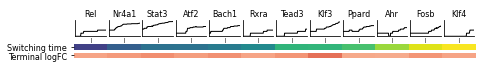

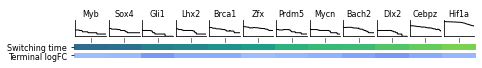

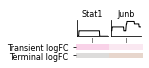

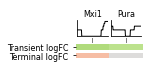

Hair-Shaft-Medulla


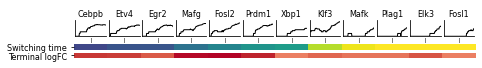

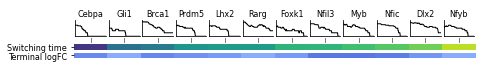

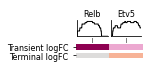

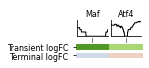

In [7]:
#Trajectory branch defined as (starting node, ending node) from trajectory inference
#See main1.ipynb
branches={
	'IRS':(3,1),
	'Hair-Shaft-Medulla':(3,2)
}
#Value range for coloring
vrange={
	'Terminal logFC':[-4.5,4.5],
	'Transient logFC':[-1.5,1.5],
	'Switching time':[0.2,0.8],
}

for branchname in branches:
	print(branchname)
	figs=d0.draw_discover(*branches[branchname],ntops=(12,12,2,2),vrange=vrange)
	plt.show()


Colorbar

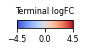

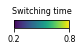

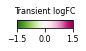

In [8]:
from operator import or_
from functools import reduce
from dictys.plot import colorbar

#Color bar font size
fs=8

colormaps=reduce(or_,[x[2] for x in figs])
for xi0 in range(len(colormaps)):
	xi=list(colormaps)[xi0]
	colormap=colormaps[xi]
	ans2=colorbar(colormap.cmap.name,colormap.norm.vmin,colormap.norm.vmax,orientation='horizontal',figsize=(1,0.15),title=xi,title_fontsize=fs)
	xticks=[colormap.norm.vmin,0,colormap.norm.vmax] if colormap.norm.vmin*colormap.norm.vmax<0 else [colormap.norm.vmin,colormap.norm.vmax]
	ans2[1].set_xticks(xticks)
	ans2[1].tick_params(axis='x',labelsize=fs)


### Animation visualization of dynamic networks
#### Animation layout

Here we use the 'notch' layout. Each row for c,d,e,f has their own set of select TFs. The layout is arbitrary and you can design your own custom layout.

```
+---+       +---+
| a |       | b |
+---+---+---+---+
| c | d | e | f |
+---+---+---+---+
| c | d | e | f |
+---+---+---+---+
```

* a: Dynamic tracking of cells used for GRN inference
* b: Dynamic scatter plot for differential regulation v.s. differential expression logFCs
* c: Dynamic plot for expression level (log CPM) of select TFs as a function of pseudo-time
* d: Dynamic plot for regulatory activity (log target count) of select TFs as a function of pseudo-time
* e: Dynamic heatmap for regulation strength from select TFs to select target genes
* f: Dynamic subnetwork graph from select TF to its targets

#### Branch independent parameters

In [9]:
from IPython.display import FileLink
from dictys.plot import layout,panel
# Number of frames (interpolated time points), use 100 or higher for finer resolution
nframe=100
# Animation FPS for saving. Determines speed of play
fps=0.10*nframe
# DPI for animation
dpi=100


#### IRS branch
##### Branch dependent customizations

In [10]:
branchname='IRS'
# Select TFs for each row's dynamic subnetwork graph
tfs_subnet=[
	['Lhx2'],
	['Stat3'],
]
# Select TFs for each row's other plots
tfs_ann=[
	['Lhx2','Dlx2','Sox4'],
	['Stat3','Klf4', 'Jun', 'Fosb'],
]
# Select genes to annotate as targets in all rows
target_ann=['Krt75','Lgr5','Mgst1','Mki67', 'Scd1']


##### Branch independent lines

Note: this step may take **> 1 hour**. Use `nframe=10` above to speed up exploratory analysis and `nframe=100` or higher for the final high-quality movie.

../output/animation-IRS.mp4

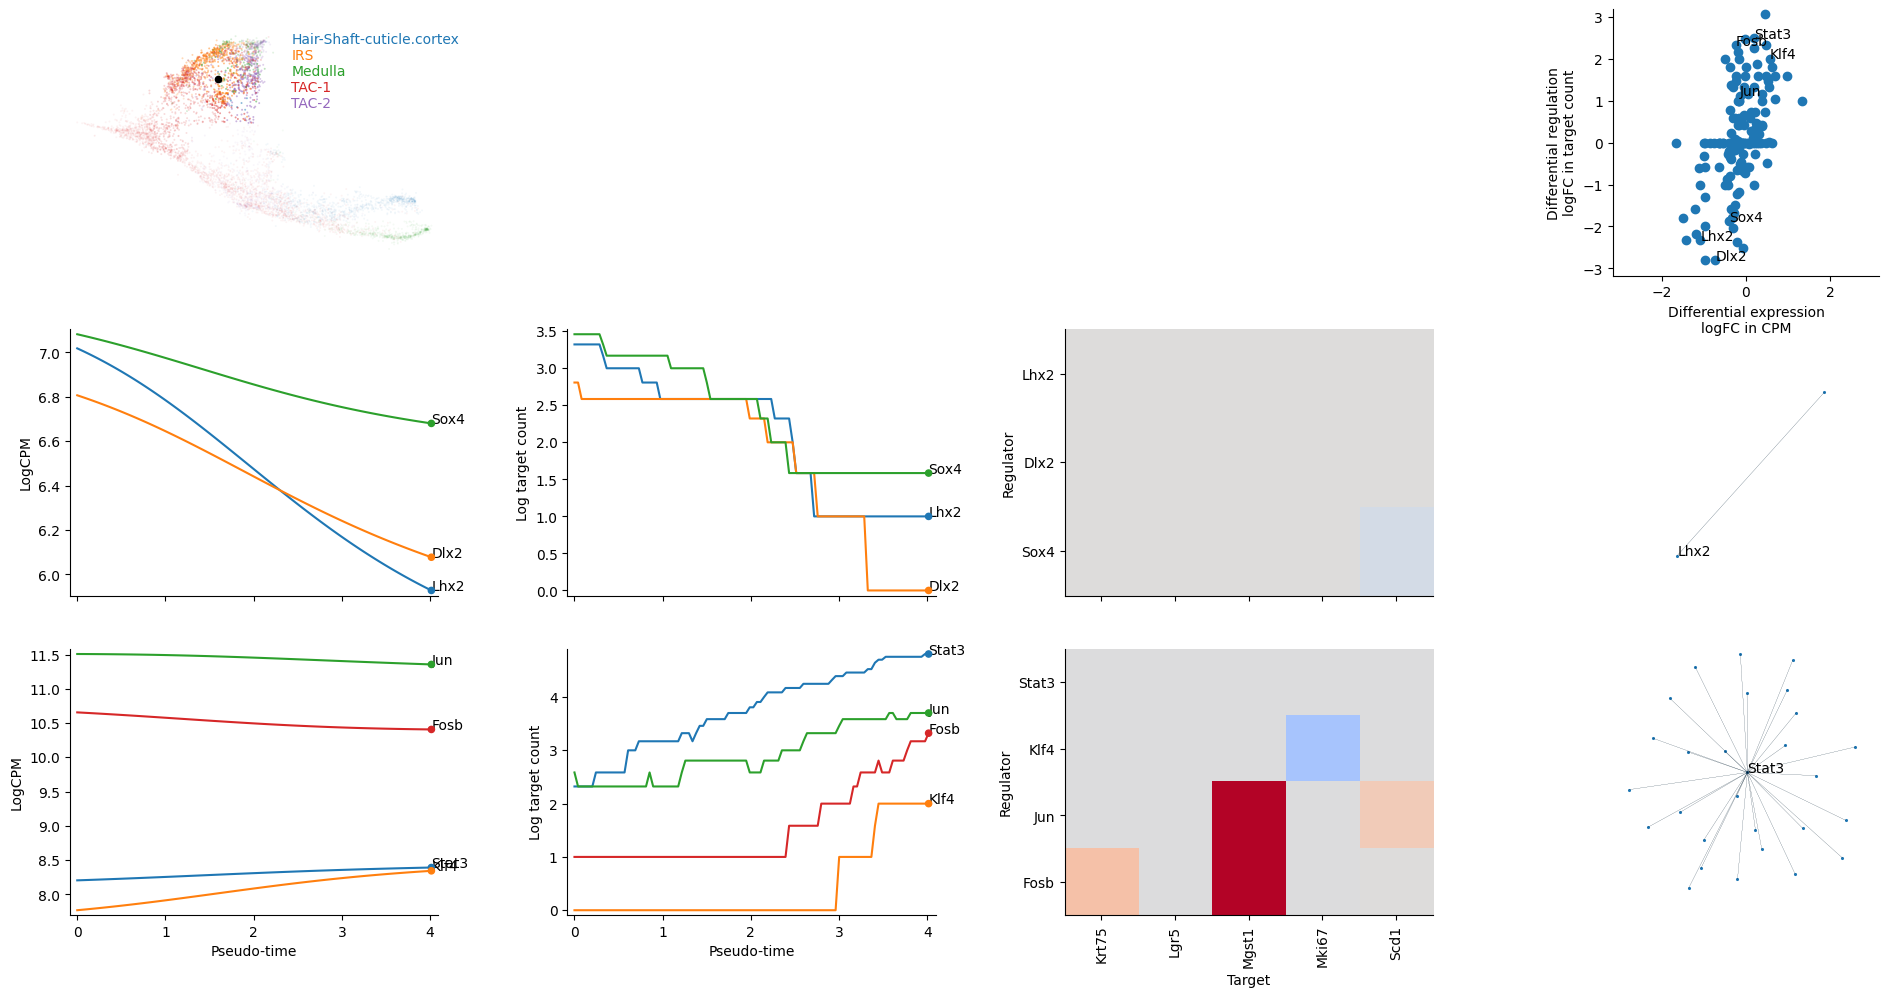

In [11]:
branch=branches[branchname]
# Draw dynamic network with notch layout
layout1=layout.notch(nframe=nframe,dpi=dpi)
pts,fig,panels,animate_ka=layout1.draw(
	d0,branch,
	# Set genes to annotate
	bcde_tfs=tfs_ann,e_targets=target_ann,f_tfs=tfs_subnet,
	# Custom legend location for long cell type name
	a_ka={'scatterka':{'legend_loc':(0.6,1)}},
	# Custom configurations for color range
	e_ka={'lim':[-0.02,0.02]},
)
ca=panel.animate_generic(pts,fig,panels)
anim=ca.animate(**animate_ka)

# Saving animation
# Option 1: Visualize animation within jupyter. This will make the notebook large especially with many frames
# from IPython.display import HTML
# HTML(anim.to_jshtml())

# Option 2: Save animation to mp4 file
# If you receive a codec related error, try a different codec, e.g. with `codec='h264'`. You can list available codecs with `ffmpeg -codecs`.
w=matplotlib.animation.writers['ffmpeg_file'](fps=fps,codec='mpeg4')
w.frame_format='jpeg'
fo=f'../output/animation-{branchname}.mp4'
anim.save(fo,writer=w,dpi='figure')
display(FileLink(fo))


#### Hair-Shaft-Medulla branch
##### Branch dependent customizations

In [12]:
branchname='Hair-Shaft-Medulla'
# Select TFs for each row's dynamic subnetwork graph
tfs_subnet=[
	['Lhx2'],
	['Runx1'],
]
# Select TFs for each row's other plots
tfs_ann=[
	['Lhx2','Dlx2','Sox4'],
	['Runx1','Prdm1'],
]
# Select genes to annotate as targets in all rows
target_ann=['Mgst1','Mki67','Krt31','Scd1','Rnaset2b']


##### Branch independent lines

../output/animation-Hair-Shaft-Medulla.mp4

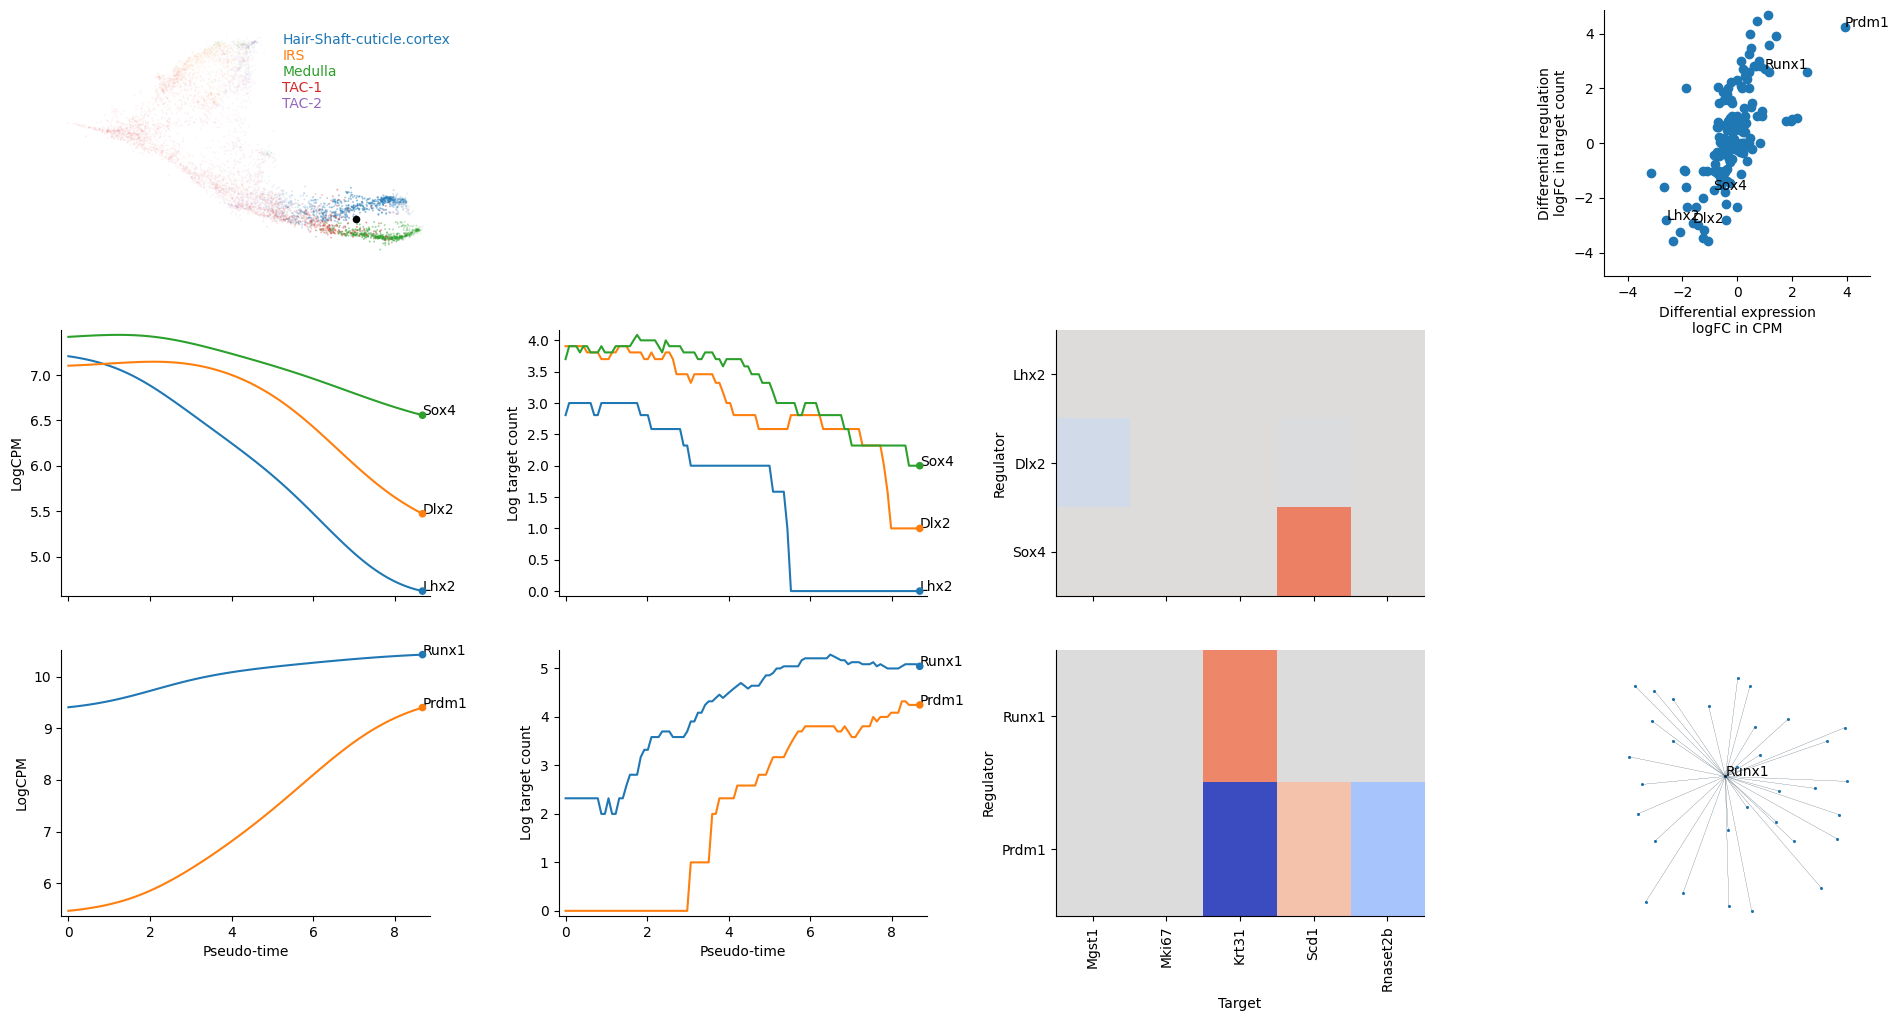

In [13]:
branch=branches[branchname]
# Draw dynamic network with notch layout
layout1=layout.notch(nframe=nframe,dpi=dpi)
pts,fig,panels,animate_ka=layout1.draw(
	d0,branch,
	# Set genes to annotate
	bcde_tfs=tfs_ann,e_targets=target_ann,f_tfs=tfs_subnet,
	# Custom legend location for long cell type name
	a_ka={'scatterka':{'legend_loc':(0.6,1)}},
	# Custom configurations for color range
	e_ka={'lim':[-0.02,0.02]},
)
ca=panel.animate_generic(pts,fig,panels)
anim=ca.animate(**animate_ka)

# Save animation to mp4 file
# If you receive a codec related error, try a different codec, e.g. with `codec='h264'`. You can list available codecs with `ffmpeg -codecs`.
w=matplotlib.animation.writers['ffmpeg_file'](fps=fps,codec='mpeg4')
w.frame_format='jpeg'
fo=f'../output/animation-{branchname}.mp4'
anim.save(fo,writer=w,dpi='figure')
display(FileLink(fo))


### Download the inferred dynamic networks to share with collaborators and community
Others can load the networks and re-analyze/re-draw them with Dictys

In [14]:
from IPython.display import FileLink
FileLink('../output/dynamic.h5')

../output/dynamic.h5